# Customer churn with a classifcation model

**Content:**
1. [Install packages and load data](#1)
1. [Data Exploration](#2)
1. [Data Preparation](#3)
1. [Feature Engineering](#4)
1. [Multivariate Analysis ](#5)
1. [Split into train- and testset](#6)
1. [Train and validate models](#7)
1. [K-fold cross validation](#8)
1. [Advanced Models I: LightGBM](#9)
1. [Advanced Models II: CatBoost](#10)

<a id="1"></a> 


## 1. Install packages and load data

In [150]:
# a) Install packages
import pandas as pd       # 'as' := we abbreviate the package for common use
import numpy as np
import seaborn as sns
import random
import os
import math
import matplotlib.pyplot as plt 
import datetime
import collections
import scipy.stats as stats                             # Fit of distribution plot
from sklearn.model_selection import train_test_split    # Split train-/testset     
from sklearn.tree import DecisionTreeClassifier         # Modeling CART Decision Tree  
from sklearn import metrics                             # Performance metrics
from sklearn.metrics import accuracy_score              # Accuracy of a model
from sklearn.metrics import classification_report       # Performance report of a classification model
from sklearn.metrics import f1_score,average_precision_score                    # f1 score of model
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler,TomekLinks
from sklearn.metrics import precision_recall_curve, auc

import graphviz as gv                                   # Needed to graph Decision Tree
import pydotplus                                        # Needed to graph Decision Tree
from IPython.display import Image                       # Needed to graph Decision Tree
from six import StringIO                                # Needed to graph Decision Tree
from sklearn.tree import export_graphviz                # Needed to graph Decision Tree
from sklearn.ensemble import RandomForestClassifier     # Modeling Random Forest
from sklearn.ensemble import AdaBoostClassifier         # Modeling AdaBoost 
from sklearn.ensemble import GradientBoostingClassifier # Modeling XGBoost
from sklearn.model_selection import KFold               # Cross-validation using stratified K-fold
from sklearn.model_selection import RandomizedSearchCV  # Randomized searching through a parameter grid

In [151]:
# b) Load data

inputdata = pd.read_csv("Churn_Modelling_undersampled.csv")

#    Get an overview of the data
inputdata.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,6038,15626452,Beatham,711,Spain,Male,32.0,5,0.00,2.0,1,1,147720.27,0
1,6553,15636407,Beatham,793,Germany,Female,34.0,5,127758.09,1.0,1,0,143357.03,0
2,6320,15768340,Beavers,642,Germany,Female,19.0,3,113905.48,1.0,1,1,176137.20,0
3,7917,15610936,Becher,562,France,Male,33.0,6,0.00,2.0,1,0,111590.35,0
4,9681,15655335,Becher,590,France,Male,36.0,1,0.00,2.0,1,0,48876.84,0
5,9229,15749679,Beck,699,France,Male,39.0,2,109724.38,1.0,1,1,180022.39,0
6,4953,15731543,Becker,679,Spain,Male,58.0,9,109327.65,1.0,1,1,3829.13,0
7,2165,15794479,Becker,767,Spain,Male,NaN,8,149083.70,1.0,1,1,190146.83,0
8,2647,15582944,Becker,425,Spain,Female,39.0,5,0.00,2.0,1,0,140941.47,0
9,878,15800228,Bednall,652,Spain,Female,42.0,4,0.00,NaN,1,1,38152.01,0


<a id="2"></a> 


## 2. Data Exploration 

In [152]:
# a) Get an overview of the data
#    Get the number of rows and columns
print('(nrow, ncol):', inputdata.shape)     

#    Show a brief summary of the numeric variables
inputdata.describe()                        # min/max, count, mean, std and percentiles

(nrow, ncol): (2913, 14)


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,2913.000000,2.913000e+03,2913.000000,2584.000000,2913.000000,2913.000000,2634.000000,2913.000000,2913.000000,2913.000000,2913.000000
mean,5046.405081,1.569137e+07,650.608994,38.209752,4.994851,76045.201177,1.521640,0.694130,0.529351,99230.436038,0.115688
std,2924.625955,7.232154e+04,96.008928,10.277533,2.871858,62710.821575,0.551649,0.460854,0.499223,57108.982643,0.319906
min,3.000000,1.556571e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.070000,0.000000
25%,2492.000000,1.562829e+07,586.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51358.660000,0.000000
50%,5039.000000,1.569065e+07,652.000000,37.000000,5.000000,96558.660000,1.000000,1.000000,1.000000,98309.270000,0.000000
75%,7589.000000,1.575586e+07,717.000000,43.000000,7.000000,127806.910000,2.000000,1.000000,1.000000,147545.650000,0.000000
max,10000.000000,1.581566e+07,850.000000,85.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [153]:
# b) Check data type of each variable
print(pd.DataFrame(inputdata.dtypes, columns=['Datatype']))

                Datatype
RowNumber          int64
CustomerId         int64
Surname           object
CreditScore        int64
Geography         object
Gender            object
Age              float64
Tenure             int64
Balance          float64
NumOfProducts    float64
HasCrCard          int64
IsActiveMember     int64
EstimatedSalary  float64
Exited             int64


In [154]:
# c) Get an overview of the NULLS in the dataset
nulls = pd.DataFrame(inputdata.isnull().sum(), columns=['# NULLS'])        # Number of NULLS 

lst={}                                                                     # Number of NULLS as a percentage
for col in inputdata.columns:                                       
    lst[col]=np.sum(inputdata.loc[:,col].isnull())/len(inputdata.loc[:,col])
percNulls = pd.DataFrame(pd.Series(lst), columns=['% NULLS'])

print(pd.concat([nulls, percNulls], axis=1))

                 # NULLS   % NULLS
RowNumber              0  0.000000
CustomerId             0  0.000000
Surname                0  0.000000
CreditScore            0  0.000000
Geography              0  0.000000
Gender                 0  0.000000
Age                  329  0.112942
Tenure                 0  0.000000
Balance                0  0.000000
NumOfProducts        279  0.095778
HasCrCard              0  0.000000
IsActiveMember         0  0.000000
EstimatedSalary        0  0.000000
Exited                 0  0.000000


In [155]:
# analyze target variable
target = 'Exited'

inputdata[target].value_counts()

0    2576
1     337
Name: Exited, dtype: int64

In [156]:
# e) Analyze categorical variables
inputdata['HasCrCard'].value_counts()

1    2022
0     891
Name: HasCrCard, dtype: int64

Text(0, 0.5, '#')

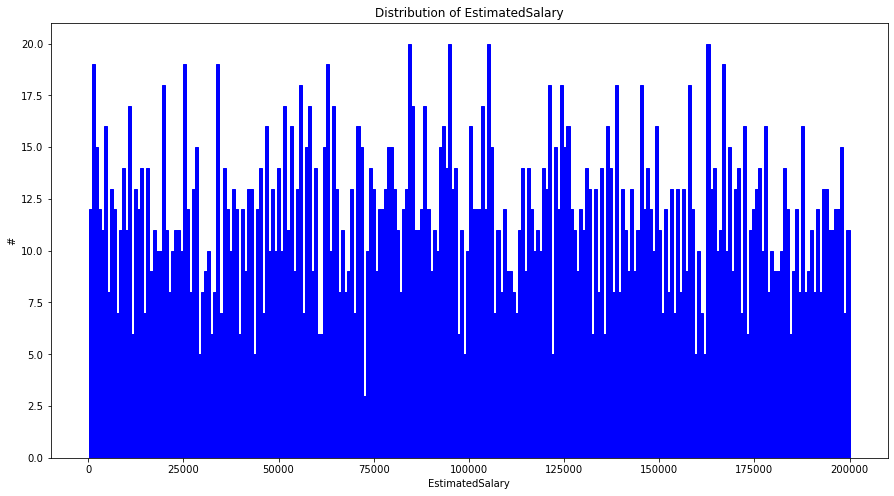

In [157]:
# f) Analyze distribution of continuous variable
variable_analyzed = 'EstimatedSalary'

plt.figure(figsize=(15,8))
plt.hist((inputdata[variable_analyzed]), bins=250, color = 'blue', edgecolor = 'blue')
plt.title('Distribution of {}'.format(variable_analyzed))
plt.xlabel(variable_analyzed)
plt.ylabel('#')

<a id="3"></a> 


## 3. Data Preparation

In [158]:
print(inputdata.shape)

(2913, 14)


In [159]:
# a) Drop outliers (where features have impossibly high values)

inputdata = inputdata[~(inputdata['Age']>=120)]
inputdata = inputdata[~(inputdata['EstimatedSalary']<0)]

In [160]:
# b) Handling missing values

# inputdata.NumOfProducts = inputdata.NumOfProducts.fillna(0)
# inputdata.Age = inputdata.Age.fillna(0)
inputdata.loc[:,['Age','NumOfProducts']] = inputdata.loc[:,['Age','NumOfProducts']].fillna(inputdata.loc[:,['Age','NumOfProducts']].mean())

<a id="4"></a> 


## 4. Feature Engineering

In [161]:
# Creating polynomial features

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
df = poly.fit_transform(inputdata[['Age',
       'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']])

df = pd.DataFrame(df)
df =df.fillna(df.mean())
inputdata = pd.concat([inputdata, df], axis=1, sort=False)
inputdata = inputdata.dropna()
inputdata.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,11,12,13,14,15,16,17,18,19,20
0,6038,15626452,Beatham,711,Spain,Male,32.0,5,0.00,2.0,...,25.0,0.00,10.0,738601.35,0.000000e+00,0.00,0.000000e+00,4.0,295440.54,2.182128e+10
1,6553,15636407,Beatham,793,Germany,Female,34.0,5,127758.09,1.0,...,25.0,638790.45,5.0,716785.15,1.632213e+10,127758.09,1.831502e+10,1.0,143357.03,2.055124e+10
2,6320,15768340,Beavers,642,Germany,Female,19.0,3,113905.48,1.0,...,9.0,341716.44,3.0,528411.60,1.297446e+10,113905.48,2.006299e+10,1.0,176137.20,3.102431e+10
3,7917,15610936,Becher,562,France,Male,33.0,6,0.00,2.0,...,36.0,0.00,12.0,669542.10,0.000000e+00,0.00,0.000000e+00,4.0,223180.70,1.245241e+10
4,9681,15655335,Becher,590,France,Male,36.0,1,0.00,2.0,...,1.0,0.00,2.0,48876.84,0.000000e+00,0.00,0.000000e+00,4.0,97753.68,2.388945e+09


In [162]:
# a) Creating new variables

#    i. Compute the avg product tenure and delta salary - balance per product
inputdata['avg_tenure'] = inputdata['Tenure'] / inputdata['NumOfProducts']
inputdata['new_money'] = (inputdata['EstimatedSalary'] - inputdata['Balance']) / inputdata['NumOfProducts']
inputdata['age_tenure'] = inputdata['Age'] / (inputdata['Tenure']+0.0001)
inputdata['age_prod'] = inputdata['Age'] / inputdata['NumOfProducts']

In [163]:
#    ii. Categorize the Credit scores based on how good it is
inputdata['Credit'] = inputdata.loc[:,'CreditScore']
inputdata.loc[inputdata['CreditScore']<630,'Credit'] = 0
inputdata.loc[(inputdata['CreditScore']>=630) & (inputdata['CreditScore']<690),'Credit'] = 1
inputdata.loc[(inputdata['CreditScore']>=690) & (inputdata['CreditScore']<720),'Credit'] = 2
inputdata.loc[inputdata['CreditScore']>=720,'Credit'] = 3

In [164]:
# b ) Dummmify the categorical variables
# Save the categorical variable columns

categoricals = ['Gender', 'Geography'
               ]

inputdata = pd.concat([pd.get_dummies(inputdata, columns=categoricals), inputdata[categoricals]], axis=1)
# We save the categorical columns before dummyfiying, as we might need them later on.

<a id="5"></a> 


## 5. Multivariate Analysis 

In [165]:
inputdata.columns.values


array(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 0, 1, 2, 3, 4, 5, 6,
       7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 'avg_tenure',
       'new_money', 'age_tenure', 'age_prod', 'Credit', 'Gender_Female',
       'Gender_Male', 'Geography_France', 'Geography_Germany',
       'Geography_Spain', 'Gender', 'Geography'], dtype=object)

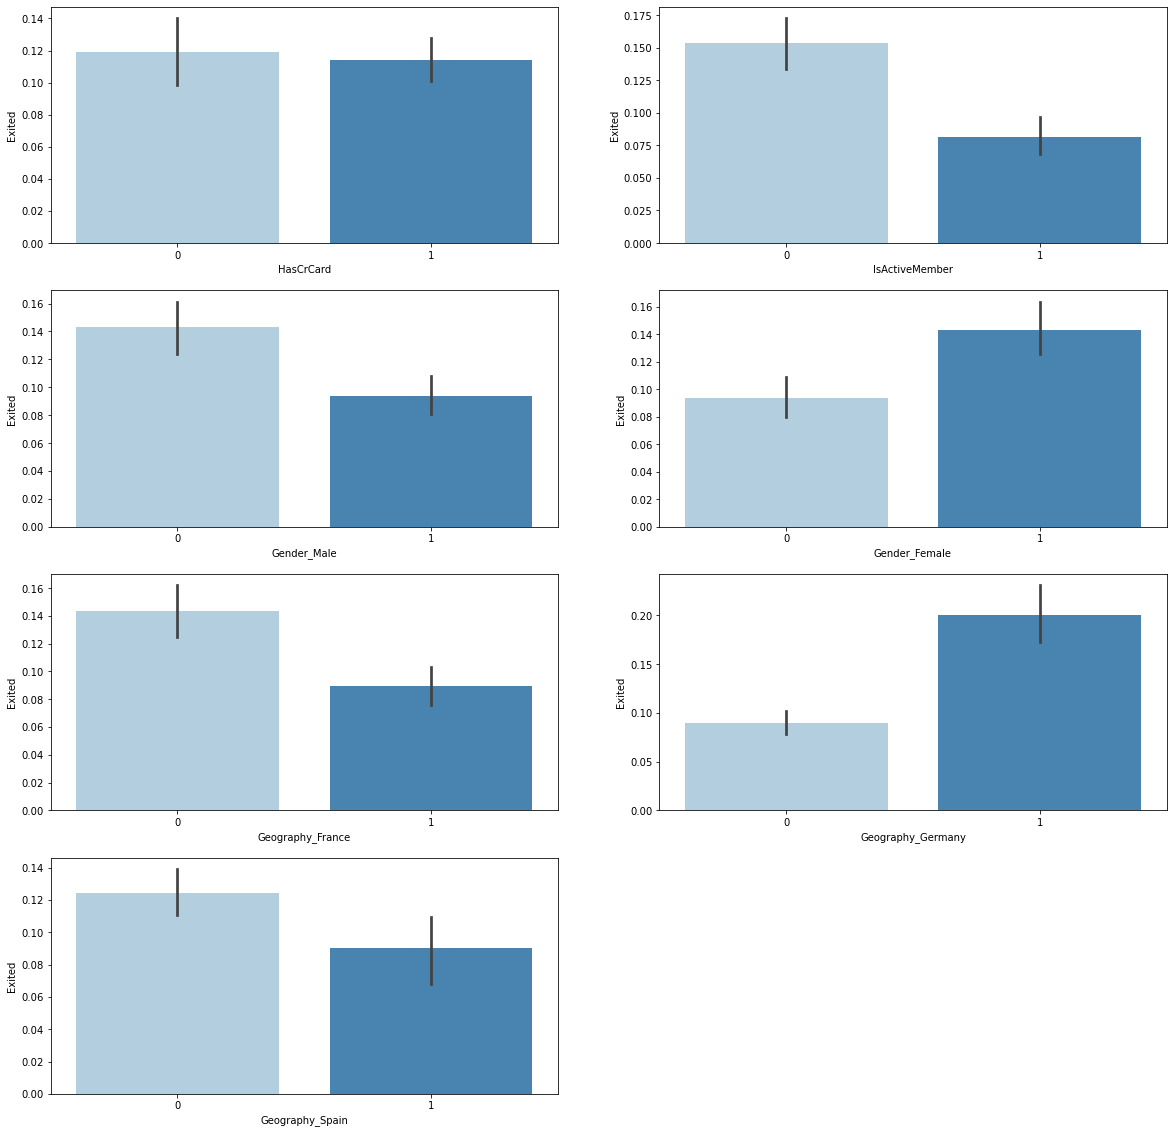

In [166]:
# a) Create barplot to see the relation between the dummy-variables and target variable
dummies = ['HasCrCard'
           ,'IsActiveMember'
           ,'Gender_Male'
           ,'Gender_Female'
           ,'Geography_France'
           ,'Geography_Germany'
           ,'Geography_Spain'
          ]


plt.figure(figsize=(20,20))
for i, column in enumerate(dummies):
    plt.subplot(math.ceil(len(dummies)/2), 2, i+1)
    sns.barplot(x=column, y=target, data=inputdata, palette='Blues')

<AxesSubplot:>

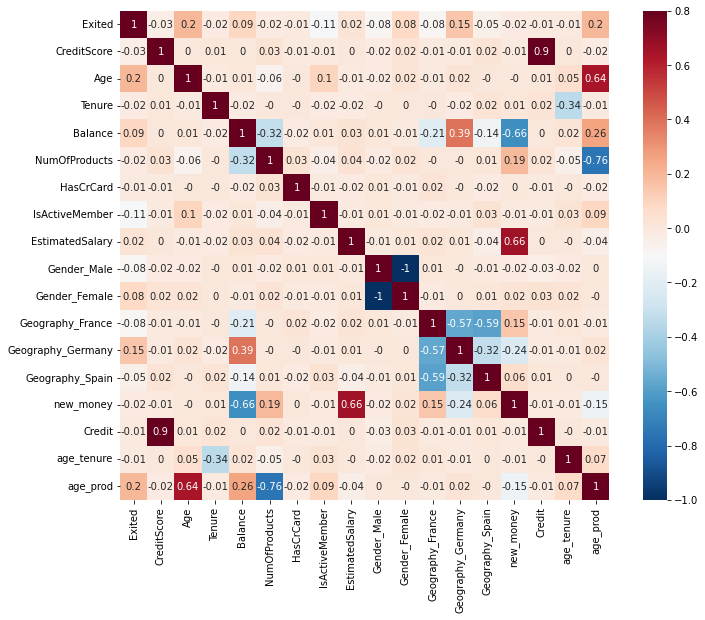

In [167]:
#  b) Show correlation matrix to look for mutual correlations
columns = ['Exited'
           ,'CreditScore'
           ,'Age'
           ,'Tenure'
           ,'Balance'
           ,'NumOfProducts'
           ,'HasCrCard'
           ,'IsActiveMember'
           ,'EstimatedSalary'
           ,'Gender_Male'
           ,'Gender_Female'
           ,'Geography_France'
           ,'Geography_Germany'
           ,'Geography_Spain'
           ,'new_money'
           ,'Credit'
           ,'age_tenure'
           ,'age_prod'
          ]

correlation = inputdata[columns]
corrmat = correlation.corr().round(2)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, cmap='RdBu_r')

<a id="6"></a> 


## 6. Split into train- and testset

In [209]:
data_train, data_test  = train_test_split(inputdata, test_size=0.2, random_state=random.seed(1618))

In [210]:
# convert all column names to strings
data_train.columns = data_train.columns.astype(str)
data_test.columns = data_test.columns.astype(str)

<a id="7"></a> 


## 7. Train and validate models

<a id="5a"></a> 
### A) Decision Tree CART

In [211]:
# get all variable names
data_train.columns.values


array(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15',
       '16', '17', '18', '19', '20', 'avg_tenure', 'new_money',
       'age_tenure', 'age_prod', 'Credit', 'Gender_Female', 'Gender_Male',
       'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender', 'Geography'], dtype=object)

In [212]:
# Define X and y 
X_variables = ['CreditScore', 'Age', 'Balance', 'NumOfProducts','IsActiveMember','EstimatedSalary', 'Gender_Female', 'Geography_Germany','age_prod'] #'CreditScore', 'Age', 'Balance', 'NumOfProducts',
       #'IsActiveMember', 'EstimatedSalary', 'Gender_Female', 'Geography_Germany''new_money', 'avg_tenure'
y_variable = 'Exited'

X_train = data_train.loc[:, X_variables]
y_train = data_train[y_variable]
X_test = data_test.loc[:, X_variables]
y_test = data_test[y_variable]

In [213]:
# a) Set model parameters 
#    Note: if Min_bucket is too large, the tree might not branch, if too small, the tree might get to big to interpret
Min_num_splits = 50                            # Minimum number of items to split
Min_bucket     = math.floor(Min_num_splits/3)  # Minimum number of items per bucket
Max_depth      = 5                             # Maximum depth of final tree (nr of levels)

In [214]:
# b) Estimate the model 
mytree = DecisionTreeClassifier(max_depth=Max_depth
                                ,min_samples_split=Min_num_splits
                                ,min_samples_leaf=Min_bucket
                                ,criterion="gini"              
                                ,splitter="best"
                                ,random_state=random.seed()
                                )

mytree.fit(X_train, y_train)     # Fit the model over the train set

DecisionTreeClassifier(max_depth=5, min_samples_leaf=16, min_samples_split=50)

In [215]:
# c) Create predictions for the test set
preds_proba = mytree.predict_proba(X_test)
preds = mytree.predict(X_test)   # Cut-off point equals 0.5

#    Show the first 5 lines of the prediction probabilities and corresponding prediction
pd.concat([pd.DataFrame(preds_proba, columns=["Prob. 0", "Prob. 1"]), pd.DataFrame(preds, columns=["Prediction"])], axis=1).head()

,Prob. 0,Prob. 1,Prediction
0,0.192308,0.807692,1
1,0.780488,0.219512,0
2,0.945841,0.054159,0
3,0.945841,0.054159,0
4,0.605263,0.394737,0


In [216]:
#    Calculate the optimal cut-off point
cost_TP = 50
cost_TN = 0
cost_FP = 50
cost_FN = 100
total_cost = math.inf

for i in np.linspace(0,1,100,endpoint=False):
    y_pred = (preds_proba[:,1]>i).astype('int')
    results = metrics.confusion_matrix(y_pred,y_test)
    TN = results[0][0]
    FN = results[0][1]
    FP = results[1][0]
    TP = results[1][1]
    
    # Calculate cutoff-point
    cost = TN*cost_TN + TP*cost_TP + FP*cost_FP + FN*cost_FN
    total_cost = min(total_cost,cost)
    if(total_cost == cost):
        opt_cutoff = i
        
print('Optimal cut-off:', opt_cutoff)

#    Create predictions for the test set according to optimal cutoff point
preds = (preds_proba[:,1] > opt_cutoff).astype('int')

Optimal cut-off: 0.39


       fpr       tpr    1-fpr        tf  thresholds
9  0.30137  0.736111  0.69863  0.037481    0.129199


[Text(-2.0, 0, ''),
 Text(0.0, 0, ''),
 Text(2.0, 0, ''),
 Text(4.0, 0, ''),
 Text(6.0, 0, ''),
 Text(8.0, 0, ''),
 Text(10.0, 0, ''),
 Text(12.0, 0, ''),
 Text(14.0, 0, ''),
 Text(16.0, 0, '')]

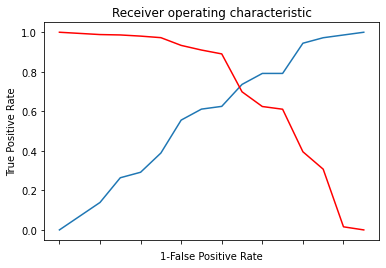

In [217]:
#    Plot tpr vs 1-fpr
fpr, tpr, t = metrics.roc_curve(y_test, preds_proba[:,1])
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i)
                    ,'1-fpr' : pd.Series(1-fpr, index = i)
                    ,'tf' : pd.Series(tpr - (1-fpr), index = i)
                    ,'thresholds' : pd.Series(t, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.title('Receiver operating characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('1-False Positive Rate')
ax.set_xticklabels([])

In [218]:
# d) Evaluate results
#    i. Create confusion matrix
print(pd.crosstab(preds, y_test))

Exited    0   1
row_0          
0       497  44
1        14  28


In [219]:
#    ii. Create classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       511
           1       0.67      0.39      0.49        72

    accuracy                           0.90       583
   macro avg       0.79      0.68      0.72       583
weighted avg       0.89      0.90      0.89       583



Feature ranking:
Feature 8 (age_prod) 0.350556
Feature 3 (NumOfProducts) 0.337543
Feature 4 (IsActiveMember) 0.129784
Feature 7 (Geography_Germany) 0.073242
Feature 1 (Age) 0.036486
Feature 0 (CreditScore) 0.026780
Feature 2 (Balance) 0.024407
Feature 6 (Gender_Female) 0.021203
Feature 5 (EstimatedSalary) 0.000000


<Figure size 540x360 with 0 Axes>

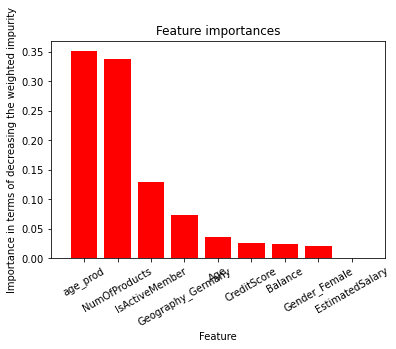

In [220]:
#    iii. Get the feature importances of the tree
importances = mytree.feature_importances_ 
std = np.std([mytree.feature_importances_], axis=0)
indices = np.argsort(importances)[::-1]

importances_features = []
print("Feature ranking:")                    # Print the feature ranking
for f in range(X_train.shape[1]):
    print("Feature %d (%s) %f" % (indices[f], X_variables[indices[f]], importances[indices[f]]))
    importances_features.append(X_variables[indices[f]])

plt.figure(figsize=(7.5,5))
plt.figure()                                 # Plot the feature importances 
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.title("Feature importances")
plt.ylabel("Importance in terms of decreasing the weighted impurity")
plt.xlabel("Feature")
plt.xticks(range(X_train.shape[1]), importances_features, rotation = 30)
plt.xlim([-1, X_train.shape[1]])
plt.show()

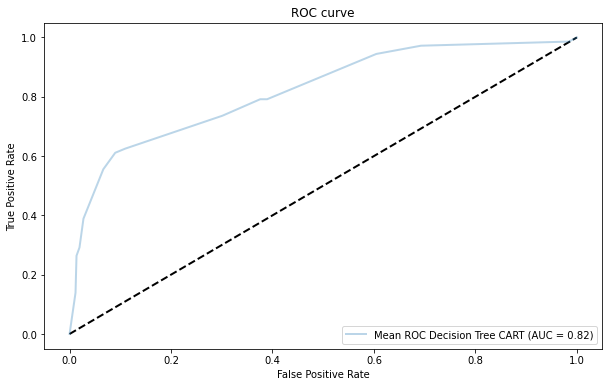

In [221]:
#    iv. Create ROC curve
fpr, tpr, t = metrics.roc_curve(y_test, preds_proba[:,1])

#     v. Calculate AUC
CART_roc_auc_tree = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')      # Plot results
plt.plot(fpr, tpr, lw=2, alpha=0.3, label='Mean ROC Decision Tree CART (AUC = %0.2f)' % (CART_roc_auc_tree))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [222]:
# e) Visualize Decision Tree
dot_data = StringIO()
export_graphviz(mytree, out_file=dot_data,           # mytree := name of your decision treee
                filled=True, rounded=True,
                feature_names=X_variables,
                special_characters=True)
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

InvocationException: GraphViz's executables not found

<a id="5c"></a> 
### B) Random Forest 

In [223]:
# Define train and test set

X_train = data_train.loc[:, X_variables]
y_train = data_train[y_variable]
X_test = data_test.loc[:, X_variables]
y_test = data_test[y_variable]

In [224]:
# a) Set model parameters 
#     Note: You can tweak the size of your forest by changing 'N_trees', but note computation time increases with size
#     Note: if Min_bucket is too large, the trees might not branch
N_trees        = 20                           # Number of trees that are estimated
Min_num_splits = 50                            # Minimum number of items to split    
Min_bucket     = math.floor(Min_num_splits/3)  # Minimum number of items per bucket
Max_depth      = 7                            # Maximum depth of each tree (nr of levels)

In [225]:
# b) Estimate the model
forest = RandomForestClassifier(n_estimators = N_trees
                                ,criterion = "gini"            
                                ,max_depth = Max_depth
                                ,min_samples_split = Min_num_splits
                                ,min_samples_leaf = Min_bucket
                                ,random_state = random.seed()
                                )

forest.fit(X_train, y_train)   # Fit the model over the train set

RandomForestClassifier(max_depth=7, min_samples_leaf=16, min_samples_split=50,
                       n_estimators=20)

In [226]:
# c) Create predictions for the test set
preds_proba = forest.predict_proba(X_test)
preds = forest.predict(X_test)   # Cut-off point equals 0.5

#    Show the first 5 lines of the prediction probabilities and corresponding prediction
pd.concat([pd.DataFrame(preds_proba, columns=["Prob. 0", "Prob. 1"]), pd.DataFrame(preds, columns=["Prediction"])], axis=1).head()

,Prob. 0,Prob. 1,Prediction
0,0.375666,0.624334,1
1,0.725325,0.274675,0
2,0.935100,0.064900,0
3,0.942931,0.057069,0
4,0.578118,0.421882,0


In [227]:
# d) Evaluate results
#    i. Create confusion matrix
print(pd.crosstab(preds, y_test))

Exited    0   1
row_0          
0       509  61
1         2  11


In [228]:
#    ii. Create classification report
print(classification_report(y_test, preds))
f1_RF = f1_score(y_test, preds)


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       511
           1       0.85      0.15      0.26        72

    accuracy                           0.89       583
   macro avg       0.87      0.57      0.60       583
weighted avg       0.89      0.89      0.86       583



Feature ranking:
Feature 1 (Age) 0.223061
Feature 8 (age_prod) 0.209564
Feature 3 (NumOfProducts) 0.196509
Feature 4 (IsActiveMember) 0.081170
Feature 2 (Balance) 0.079938
Feature 7 (Geography_Germany) 0.071597
Feature 0 (CreditScore) 0.056517
Feature 5 (EstimatedSalary) 0.052879
Feature 6 (Gender_Female) 0.028765


<Figure size 540x360 with 0 Axes>

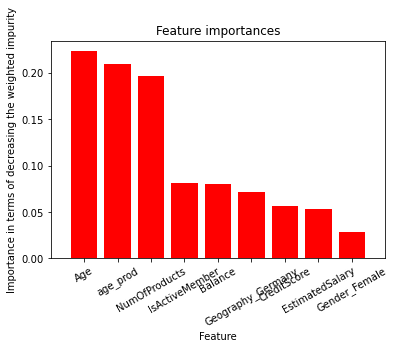

In [229]:
#    iii. Get the feature importances of the forest
importances = forest.feature_importances_ 
std = np.std([forest.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

importances_features = []
print("Feature ranking:")                    # Print the feature ranking
for f in range(X_train.shape[1]):
    print("Feature %d (%s) %f" % (indices[f], X_variables[indices[f]], importances[indices[f]]))
    importances_features.append(X_variables[indices[f]])

plt.figure(figsize=(7.5,5))
plt.figure()                                 # Plot the feature importances 
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.title("Feature importances")
plt.ylabel("Importance in terms of decreasing the weighted impurity")
plt.xlabel("Feature")
plt.xticks(range(X_train.shape[1]), importances_features, rotation = 30)
plt.xlim([-1, X_train.shape[1]])
plt.show()

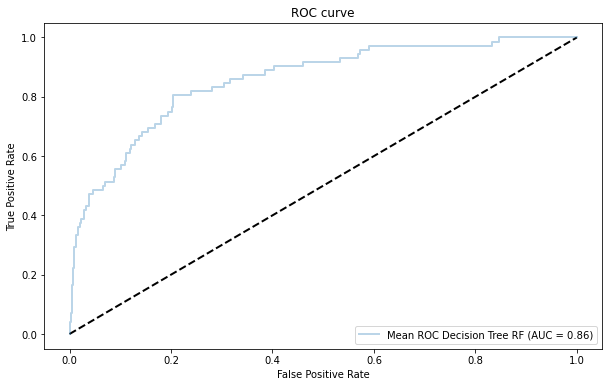

In [230]:
#    iv. Create ROC curve
fpr, tpr, t = metrics.roc_curve(y_test, preds_proba[:,1])

#     v. Calculate AUC
RF_roc_auc_tree = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')      # Plot results
plt.plot(fpr, tpr, lw=2, alpha=0.3, label='Mean ROC Decision Tree RF (AUC = %0.2f)' % (RF_roc_auc_tree))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

<a id="5d"></a> 
### C) ADABOOST (Adaptive Boosting Model)

In [231]:
# Define X and y 

X_train = data_train.loc[:, X_variables]
y_train = data_train[y_variable]
X_test = data_test.loc[:, X_variables]
y_test = data_test[y_variable]

In [232]:
# a) Set model parameters 
#     Note: You can tweak the size of your boost by changing 'N_trees', but note computation time increases with size
#     Note: if Min_bucket is too large, the trees might not branch
N_trees        = 5                          # Number of trees that are estimated
Min_num_splits = 50                            # Minimum number of items to split    
Min_bucket     = math.floor(Min_num_splits/3)  # Minimum number of items per bucket
Max_depth      = 5                             # Maximum depth of each tree (nr of levels)
Learning_rate  = 0.6                            # The learning rate

In [233]:
# b) Estimate model
adaptboost = AdaBoostClassifier(n_estimators=N_trees
                                ,base_estimator=DecisionTreeClassifier(max_depth = Max_depth
                                                                       ,min_samples_split = Min_num_splits
                                                                       ,min_samples_leaf = Min_bucket
                                                                       ,criterion = "gini"              
                                                                       ,splitter = "best"
                                                                       )
                                ,learning_rate=Learning_rate
                               )

adaptboost.fit(X_train, y_train)      # Fit the model over the train set

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf=16,
                                                    min_samples_split=50),
                   learning_rate=0.6, n_estimators=5)

In [234]:
# c) Create predictions for the test set
preds_proba = adaptboost.predict_proba(X_test)
preds = adaptboost.predict(X_test)   # Cut-off point equals 0.5

#    Show the first 5 lines of the prediction probabilities and corresponding prediction
pd.concat([pd.DataFrame(preds_proba, columns=["Prob. 0", "Prob. 1"]), pd.DataFrame(preds, columns=["Prediction"])], axis=1).head()

,Prob. 0,Prob. 1,Prediction
0,0.358288,0.641712,1
1,0.562116,0.437884,0
2,0.719167,0.280833,0
3,0.759643,0.240357,0
4,0.516803,0.483197,0


In [235]:
# d) Evaluate results
#    i. Create confusion matrix
print(pd.crosstab(preds, y_test))

Exited    0   1
row_0          
0       503  51
1         8  21


In [236]:
#    ii. Create classification report
print(classification_report(y_test, preds))
f1_ADA = f1_score(y_test, preds)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       511
           1       0.72      0.29      0.42        72

    accuracy                           0.90       583
   macro avg       0.82      0.64      0.68       583
weighted avg       0.89      0.90      0.88       583



Feature ranking:
Feature 2 (Balance) 0.254007
Feature 5 (EstimatedSalary) 0.187719
Feature 8 (age_prod) 0.152942
Feature 3 (NumOfProducts) 0.134866
Feature 1 (Age) 0.115086
Feature 0 (CreditScore) 0.053551
Feature 4 (IsActiveMember) 0.045824
Feature 7 (Geography_Germany) 0.037337
Feature 6 (Gender_Female) 0.018668


<Figure size 540x360 with 0 Axes>

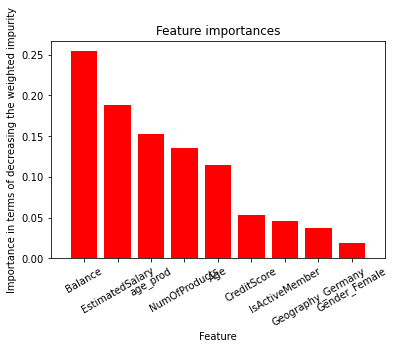

In [237]:
#    iii. Get the feature importances of the Adaboost
importances = adaptboost.feature_importances_ 
std = np.std([adaptboost.feature_importances_ for tree in adaptboost.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

importances_features = []
print("Feature ranking:")                    # Print the feature ranking
for f in range(X_train.shape[1]):
    print("Feature %d (%s) %f" % (indices[f], X_variables[indices[f]], importances[indices[f]]))
    importances_features.append(X_variables[indices[f]])

plt.figure(figsize=(7.5,5))
plt.figure()                                 # Plot the feature importances 
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.title("Feature importances")
plt.ylabel("Importance in terms of decreasing the weighted impurity")
plt.xlabel("Feature")
plt.xticks(range(X_train.shape[1]), importances_features, rotation = 30)
plt.xlim([-1, X_train.shape[1]])
plt.show()

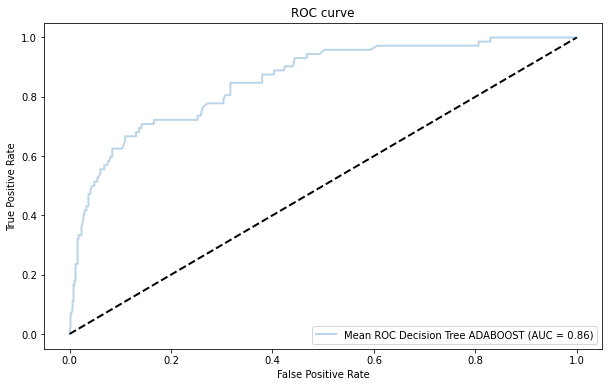

In [238]:
#    iv. Create ROC curve
fpr, tpr, t = metrics.roc_curve(y_test, preds_proba[:,1])

#     v. Calculate AUC
ADA_roc_auc_tree = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')      # Plot results
plt.plot(fpr, tpr, lw=2, alpha=0.3, label='Mean ROC Decision Tree ADABOOST (AUC = %0.2f)' % (ADA_roc_auc_tree))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\geertekoster\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 0, 'Number of estimators')

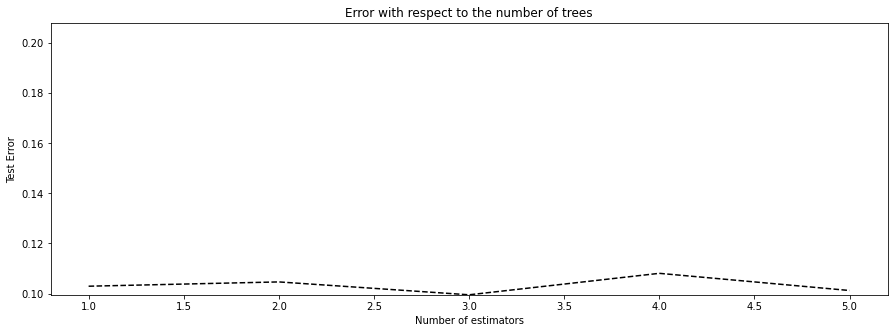

In [239]:
# e) Plot error with respect to number of estimators (trees)
trained_adaptboost = adaptboost.fit(X_train, y_train)  

real_test_errors = []
for real_test_predict in trained_adaptboost.staged_predict(X_test):
    real_test_errors.append(1. - accuracy_score(real_test_predict, np.ravel(y_test)))
n_trees_real = len(trained_adaptboost)
real_estimator_errors = trained_adaptboost.estimator_errors_[:n_trees_real]
plt.figure(figsize=(15, 5))

plt.plot(range(1, n_trees_real + 1),
         real_test_errors, c='black',
         linestyle='dashed')
plt.ylim(min(real_test_errors), max(real_test_errors)+0.1)
plt.title('Error with respect to the number of trees')
plt.ylabel('Test Error')
plt.xlabel('Number of estimators')

<a id="5e"></a> 
### D) XGBoost

['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Gender_Female', 'Geography_Germany', 'age_prod']
Feature ranking:
Feature 8 (age_prod) 0.212679
Feature 5 (EstimatedSalary) 0.197091
Feature 3 (NumOfProducts) 0.134639
Feature 0 (CreditScore) 0.110888
Feature 2 (Balance) 0.110835
Feature 1 (Age) 0.074470
Feature 4 (IsActiveMember) 0.073705
Feature 7 (Geography_Germany) 0.058175
Feature 6 (Gender_Female) 0.027517


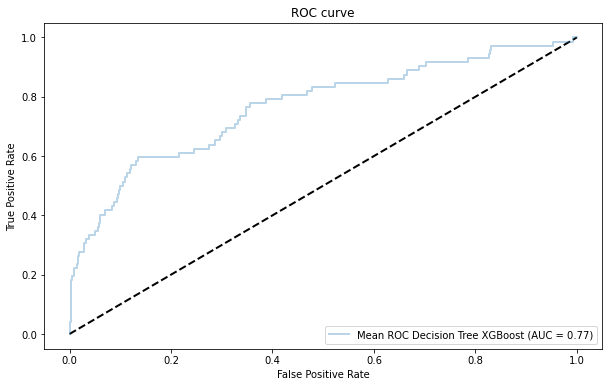

In [240]:
# Define X and y 
# X_variables = [''                 # ADJUST VARIABLES TO THOSE YOU WISH TO INCLUDE

#               ]
# y_variable = ''

X_train = data_train.loc[:, X_variables]
y_train = data_train[y_variable]
X_test = data_test.loc[:, X_variables]
y_test = data_test[y_variable]

print(X_variables)

# a) Set model parameters 
N_trees        = 20                         # Number of trees that are estimated
Max_depth      = 5                             # Maximum depth of each tree (nr of levels)
Learning_rate  = 1                             # The learning rate ('eta')
Min_bucket     = 10                           # Minimum number of items per bucket
Subsample      = 1                           # Subsample ratio of the training instance
Verbose        = 0                             # Whether to print messages while running boosting

# b) Estimate model
XGB = GradientBoostingClassifier( random_state=12,
     n_estimators=N_trees
                         ,max_depth=Max_depth 
                         ,learning_rate=Learning_rate
                         ,min_samples_leaf=Min_bucket
                         ,subsample=Subsample
                         ,verbose=Verbose
                      )
XGB.fit(X_train, y_train)      # Fit the model over the train set

# c) Create predictions for the test set
preds_proba = XGB.predict_proba(X_test)
preds = XGB.predict(X_test)   # Cut-off point equals 0.5

#    Show the first 5 lines of the prediction probabilities and corresponding prediction
#pd.concat([pd.DataFrame(preds_proba, columns=["Prob. 0", "Prob. 1"]), pd.DataFrame(preds, columns=["Prediction"])], axis=1).head()

# d) Evaluate results
#    i. Create confusion matrix
#print(pd.crosstab(preds, y_test))

#    ii. Create classification report
#print(classification_report(y_test, preds))
f1_XGB = f1_score(y_test, preds)

#    iii. Get the feature importances of the XGBoost
importances = XGB.feature_importances_ 
std = np.std([XGB.feature_importances_], axis=0)
indices = np.argsort(importances)[::-1]

importances_features = []
print("Feature ranking:")                    # Print the feature ranking
for f in range(X_train.shape[1]):
    print("Feature %d (%s) %f" % (indices[f], X_variables[indices[f]], importances[indices[f]]))
    importances_features.append(X_variables[indices[f]])

if False:
    plt.figure(figsize=(7.5,5))
    plt.figure()                                 # Plot the feature importances 
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.title("Feature importances")
    plt.ylabel("Importance in terms of decreasing the weighted impurity")
    plt.xlabel("Feature")
    plt.xticks(range(X_train.shape[1]), importances_features, rotation = 30)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

# Create ROC curve
fpr, tpr, t = metrics.roc_curve(y_test, preds_proba[:,1])

# Calculate AUC
XGB_roc_auc_tree = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')      # Plot results
plt.plot(fpr, tpr, lw=2, alpha=0.3, label='Mean ROC Decision Tree XGBoost (AUC = %0.2f)' % (XGB_roc_auc_tree))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [243]:
# Define X and y
X_variables = ['CreditScore',               'Age',            'Tenure',
                 'Balance',     'NumOfProducts',         'HasCrCard',
          'IsActiveMember',   'EstimatedSalary',           
                    '0', '1', '2', 
                   '3','4',  '5', 
                   '6', '7', '8', 
                   '9', '10', '11', 
                   '12', '13', '14', 
                   '15', '16', '17', 
                   '18', '19', '20',
              'avg_tenure',         'new_money',        'age_tenure',
                'age_prod',            'Credit',     'Gender_Female',
             'Gender_Male',  'Geography_France', 'Geography_Germany',
         'Geography_Spain']
y_variable = 'Exited'

# Sampling methods
desiredPercentage = 0.1 # Decide the percentage that you want in over/under sampling
desiredFraction = desiredPercentage/(1-desiredPercentage)
ranOS = RandomOverSampler(sampling_strategy=desiredFraction, random_state=1) # Oversampling
ranUS = RandomUnderSampler(sampling_strategy=desiredFraction, random_state=1) # Undersampling
smt = SMOTE(k_neighbors=2) # SMOTE
#Bonus: tweak the number of neighbors to maximize results
#TL = TomekLinks('not majority') # TomekLinks

X_train = data_train.loc[:, X_variables]
y_train = data_train[y_variable]
X_test = data_test.loc[:, X_variables]
X_test.columns = X_test.columns.astype(str)

y_test = data_test[y_variable]

X_train_balanced, y_train_balanced = X_train, y_train
X_train_balanced.columns = X_train_balanced.columns.astype(str)
X_train_balanced, y_train_balanced = smt.fit_resample(X_train, y_train) # Use sampling method


# Estimate model
XGB = GradientBoostingClassifier( random_state=12
                         ,n_estimators=10                         # Number of trees that are estimated
                         ,max_depth=3                             # Maximum depth of each tree (nr of levels) 
                         ,learning_rate=0.5                             # The learning rate ('eta')
                         ,min_samples_leaf=1                           # Minimum number of items per bucket
                         ,max_features='sqrt'
                         ,subsample=0.8                           # Subsample ratio of the training instance
                         ,verbose=0                             # Whether to print messages while running boosting
                      )
XGB.fit(X_train_balanced, y_train_balanced)

# d) Create predictions for the test set and calculate AUC
preds_proba = XGB.predict_proba(X_test)
preds = XGB.predict(X_test)   # Cut-off point equals 0.5
fpr, tpr, t = metrics.roc_curve(y_test, preds_proba[:, 1])  
roc_auc_xgboost = metrics.auc(fpr, tpr)
print('Area under the ROC Curve = {}'.format(roc_auc_xgboost))

Area under the ROC Curve = 0.785659926070885


### Compare models

In [244]:
print('AUC Decision Tree:', CART_roc_auc_tree)
print('AUC Random Forest:', RF_roc_auc_tree)
print('AUC Adaptive Boosting:', ADA_roc_auc_tree)
print('AUC XGBoost:', roc_auc_xgboost)

AUC Decision Tree: 0.8202598390954556
AUC Random Forest: 0.8566536203522506
AUC Adaptive Boosting: 0.8556479669493369
AUC XGBoost: 0.785659926070885


<a id="8"></a> 


## 8. K-fold cross validation

The code below iterates through several data balancing methods and several (randomly selected) hyperparameter configurations for each of the four model techniques.

In [245]:
# Define X and y
X_variables = ['CreditScore',               'Age',            'Tenure',
                 'Balance',     'NumOfProducts',         'HasCrCard',
          'IsActiveMember',   'EstimatedSalary',           
                    '0', '1', '2', 
                   '3','4',  '5', 
                   '6', '7', '8', 
                   '9', '10', '11', 
                   '12', '13', '14', 
                   '15', '16', '17', 
                   '18', '19', '20',
              'avg_tenure',         'new_money',        'age_tenure',
                'age_prod',            'Credit',     'Gender_Female',
             'Gender_Male',  'Geography_France', 'Geography_Germany',
         'Geography_Spain']
y_variable = 'Exited'

X_train = data_train.loc[:, X_variables]
y_train = data_train[y_variable]
X_test = data_test.loc[:, X_variables]
y_test = data_test[y_variable]

# Sampling methods
desiredPercentage = 0.5 # Decide the percentage that you want in over/under sampling
desiredFraction = desiredPercentage/(1-desiredPercentage)

ranOS = RandomOverSampler(sampling_strategy=desiredFraction, random_state=1) # Oversampling
ranUS = RandomUnderSampler(sampling_strategy=desiredFraction, random_state=1) # Undersampling
smt = SMOTE(k_neighbors=2) # SMOTE (tweak the number of neighbors to maximize results)
#TL = TomekLinks('not majority') # TomekLinks

sampling_methods=[None, ranOS, ranUS, smt]
sampling_method_names=['None', 'Oversampling', 'Undersampling', 'SMOTe']

# Define parameter grid. Note: some parameters apply to all model techniques, some only to one or some of them
criterion         = ["gini"]
learning_rate     = [0.05, 0.1, 0.2, 0.5, 1.0]
max_depth         = [1, 2, 3, 4, 5, 6, 7, 8]
max_features      = [None, 'sqrt', 'log2', 0.5, 0.2, 0.1, 0.05]
min_samples_leaf  = [1, 2, 5, 10, 20, 50]
min_samples_split = [2, 5, 10, 20, 50, 100, 200]
n_estimators      = [10, 20, 50, 100, 200, 500, 1000]
splitter          = ["best"]
subsample         = [0.7, 0.8, 0.9, 1.0]

n_iterations = 10 # Number of iterations to use in each random search

aucs = pd.DataFrame(index=range(0, len(sampling_methods)), columns=['Sampling method', 'Decision Tree','Random Forest','Adaboost','XGBoost'])
for i in range(len(sampling_methods)):
    
    j='Sampling method'
    sampling_method = sampling_methods[i]
    sampling_method_name = sampling_method_names[i]
    if sampling_method == None:
        X_train_balanced, y_train_balanced = X_train, y_train
    else:
        X_train_balanced, y_train_balanced = sampling_method.fit_resample(X_train, y_train) # Use sampling method
    aucs.loc[i,j] = sampling_method_name

    # a) Decision Tree CART
    j='Decision Tree'
    print(sampling_method_name, '-', j)
    dt_params = dict(
        criterion         = criterion         ,
        max_depth         = max_depth         ,
        max_features      = max_features      ,
        min_samples_leaf  = min_samples_leaf  ,
        min_samples_split = min_samples_split ,
        splitter          = splitter          
    )
    dt_search = RandomizedSearchCV(DecisionTreeClassifier(), dt_params, n_iter=n_iterations, verbose=False)
    dt_search = dt_search.fit(X_train_balanced, y_train_balanced)
    dt_model = dt_search.best_estimator_
    preds_proba = dt_model.predict_proba(X_test)
    aucs.loc[i,j] = average_precision_score(y_test, preds_proba[:,1])           # Calculate AP
    
    # b) Random Forest
    j='Random Forest'
    print(sampling_method_name, '-', j)
    rf_params = dict(
        criterion         = criterion         ,
        max_depth         = max_depth         ,
        max_features      = max_features      ,
        min_samples_leaf  = min_samples_leaf  ,
        min_samples_split = min_samples_split ,
        n_estimators      = n_estimators      
    )
    rf_search = RandomizedSearchCV(RandomForestClassifier(), rf_params, n_iter=n_iterations, verbose=False)
    rf_search = rf_search.fit(X_train_balanced, y_train_balanced)
    rf_model = rf_search.best_estimator_
    preds_proba = rf_model.predict_proba(X_test)
    aucs.loc[i,j] = average_precision_score(y_test, preds_proba[:,1])           # Calculate AP
    
    # c) Adaboost
    j='Adaboost'
    print(sampling_method_name, '-', j)
    ada_params = dict(
        base_estimator__criterion         = criterion         ,
        learning_rate                     = learning_rate     ,
        base_estimator__max_depth         = max_depth         ,
        base_estimator__max_features      = max_features      ,
        base_estimator__min_samples_leaf  = min_samples_leaf  ,
        base_estimator__min_samples_split = min_samples_split ,
        n_estimators                      = n_estimators      ,
        base_estimator__splitter          = splitter          
    )
    ada_search = RandomizedSearchCV(AdaBoostClassifier(base_estimator = DecisionTreeClassifier()), ada_params, n_iter=n_iterations, verbose=False)
    ada_search = ada_search.fit(X_train_balanced, y_train_balanced)
    ada_model = ada_search.best_estimator_
    preds_proba = ada_model.predict_proba(X_test)
    aucs.loc[i,j] = metrics.auc(fpr, tpr)           # Calculate AUC
    
    # d) XGBoost
    j='XGBoost'
    print(sampling_method_name, '-', j)
    xgb_params = dict(
        learning_rate     = learning_rate     ,
        max_depth         = max_depth         ,
        max_features      = max_features      ,
        min_samples_leaf  = min_samples_leaf  ,
        min_samples_split = min_samples_split ,
        n_estimators      = n_estimators      ,
        subsample         = subsample         
    )
    xgb_search = RandomizedSearchCV(GradientBoostingClassifier(), xgb_params, n_iter=n_iterations, verbose=False)
    xgb_search = xgb_search.fit(X_train_balanced, y_train_balanced)
    xgb_model = xgb_search.best_estimator_
    preds_proba = xgb_model.predict_proba(X_test)
    aucs.loc[i,j] = metrics.auc(fpr, tpr)           # Calculate AUC

aucs

None - Decision Tree
None - Random Forest
None - Adaboost
None - XGBoost
Oversampling - Decision Tree
Oversampling - Random Forest
Oversampling - Adaboost


KeyboardInterrupt: 

In [ ]:
# Get feature importances from your model of choice
model = xgb_model # Choose between dt_model, rf_model, ada_model, xgb_model

importances = model.feature_importances_ 
std = np.std([importances], axis=0)
indices = np.argsort(importances)[::-1]

importances_features = []
print("Feature ranking:")                    # Print the feature ranking
for f in range(X_train.shape[1]):
    print("Feature %d (%s) %f" % (indices[f], X_variables[indices[f]], importances[indices[f]]))
    importances_features.append(X_variables[indices[f]])

plt.figure(figsize=(7.5,5))
plt.figure()                                 # Plot the feature importances 
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.title("Feature importances")
plt.ylabel("Importance in terms of decreasing the weighted impurity")
plt.xlabel("Feature")
plt.xticks(range(X_train.shape[1]), importances_features, rotation = 30)
plt.xlim([-1, X_train.shape[1]])
plt.show()

<a id="9"></a> 


## 9. Advanced Models I: LightGBM

In [ ]:
# Import relevant package
import lightgbm as lgb
import time

# Define X and y 
# X_variables = [''                 # ADJUST VARIABLES TO THOSE YOU WISH TO INCLUDE

#               ]
# y_variable = ''

X_train = data_train.loc[:, X_variables]
y_train = data_train[y_variable]
X_test = data_test.loc[:, X_variables]
y_test = data_test[y_variable]

print(X_variables)

# a) Set model parameters 
N_trees           = 100                           # Number of trees that are estimated
Max_depth         = -1                            # Maximum depth of each tree (nr of levels); -1 means no limit
Learning_rate     = 0.1                           # The learning rate ('eta')
Min_child_samples = 10                            # Minimum number of items per bucket
Min_child_weight  = 0.001                         # Minimum sum of instance weight (hessian) needed in a child (leaf).
Subsample         = 1                             # Subsample ratio of the training instance
Num_leaves        = 70                            # Maximum number of leafs per tree

# Note: there are way more hyperparameters to tune. You can find them well-explained here: 
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# The values above are not tuned and optimized yet

# b) Estimate model
lgb_model = lgb.LGBMClassifier(
                         n_estimators=N_trees
                        ,max_depth=Max_depth 
                        ,learning_rate=Learning_rate
                        ,min_child_weight=Min_child_weight
                        ,min_child_samples=Min_child_samples
                        ,subsample=Subsample
                        ,num_leaves=Num_leaves
                       )

lgb_model.fit(X_train, y_train)      # Fit the model over the train set

# c) Create predictions for the test set
preds_proba = lgb_model.predict_proba(X_test)
preds = lgb_model.predict(X_test)   # Cut-off point equals 0.5

#    Show the first 5 lines of the prediction probabilities and corresponding prediction
#pd.concat([pd.DataFrame(preds_proba, columns=["Prob. 0", "Prob. 1"]), pd.DataFrame(preds, columns=["Prediction"])], axis=1).head()

# d) Evaluate results
#    i. Create confusion matrix
#print(pd.crosstab(preds, y_test))

#    ii. Create classification report
#print(classification_report(y_test, preds))
f1_lgb_model = f1_score(y_test, preds)

#    iii. Get the feature importances of the lgb_modeloost
importances = lgb_model.feature_importances_ 
std = np.std([lgb_model.feature_importances_], axis=0)
indices = np.argsort(importances)[::-1]

importances_features = []
print("Feature ranking:")                    # Print the feature ranking
for f in range(X_train.shape[1]):
    print("Feature %d (%s) %f" % (indices[f], X_variables[indices[f]], importances[indices[f]]))
    importances_features.append(X_variables[indices[f]])

if False:
    plt.figure(figsize=(7.5,5))
    plt.figure()                                 # Plot the feature importances 
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.title("Feature importances")
    plt.ylabel("Importance in terms of decreasing the weighted impurity")
    plt.xlabel("Feature")
    plt.xticks(range(X_train.shape[1]), importances_features, rotation = 30)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

# Create ROC curve
fpr, tpr, t = metrics.roc_curve(y_test, preds_proba[:,1])

# Calculate AUC
lgb_model_roc_auc_tree = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')      # Plot results
plt.plot(fpr, tpr, lw=2, alpha=0.3, label='Mean ROC Decision Tree LightGBM (AUC = %0.2f)' % (lgb_model_roc_auc_tree))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

<a id="10"></a> 


## 10. Advanced Models II: CatBoost

In [ ]:
# Import relevant package
import catboost as cat
import time

# Define X and y 
X_variables = ['CreditScore',               'Age',            'Tenure',
                 'Balance',     'NumOfProducts',         'HasCrCard',
          'IsActiveMember',   'EstimatedSalary',           
                    '0', '1', '2', 
                   '3','4',  '5', 
                   '6', '7', '8', 
                   '9', '10', '11', 
                   '12', '13', '14', 
                   '15', '16', '17', 
                   '18', '19', '20',
              'avg_tenure',         'new_money',        'age_tenure',
                'age_prod',            'Credit',     'Gender_Female',
             'Gender_Male', 'Geography'] # Note here how we remove the dummies from Geography

X_train = data_train.loc[:, X_variables]
y_train = data_train[y_variable]
X_test = data_test.loc[:, X_variables]
y_test = data_test[y_variable]

# Because we use CatBoost, we can leverage its abilitiy to handle categoricals in a clever way
# For that, we need the column indices of the cat_features
cat_features=[X_variables.index("Geography")]

# a) Set model parameters 
N_trees        = 100                           # Number of trees that are estimated
Max_depth      = 5                             # Maximum depth of each tree (nr of levels)
Learning_rate  = 1                             # The learning rate ('eta')
Subsample      = 1                             # Subsample ratio of the training instance
Silent         = True                          # Whether to print messages while running boosting

# Note: there are way more hyperparameters to tune. You can find them well-explained here: 
# https://catboost.ai/docs/concepts/parameter-tuning.html
# The values above are not tuned and optimized yet

# b) Estimate model
cat_model = cat.CatBoostClassifier(
                        n_estimators=N_trees
                        ,max_depth=Max_depth 
                        ,learning_rate=Learning_rate
                        ,subsample=Subsample
                        ,silent=Silent
                        ,cat_features=cat_features 
                       )
# You can uncomment the cat_features if you don't want to use this. 
# Given that we don't have many categories, this should not matter much. 
# But we leave it up to you to find out what the difference in speed and performance is!

cat_model.fit(X_train, y_train)      # Fit the model over the train set

# c) Create predictions for the test set
preds_proba = cat_model.predict_proba(X_test)
preds = cat_model.predict(X_test)   # Cut-off point equals 0.5

#    Show the first 5 lines of the prediction probabilities and corresponding prediction
#pd.concat([pd.DataFrame(preds_proba, columns=["Prob. 0", "Prob. 1"]), pd.DataFrame(preds, columns=["Prediction"])], axis=1).head()

# d) Evaluate results
#    i. Create confusion matrix
#print(pd.crosstab(preds, y_test))

#    ii. Create classification report
#print(classification_report(y_test, preds))
f1_cat_model = f1_score(y_test, preds)

#    iii. Get the feature importances of the cat_modeloost
importances = cat_model.feature_importances_ 
std = np.std([cat_model.feature_importances_], axis=0)
indices = np.argsort(importances)[::-1]

importances_features = []
print("Feature ranking:")                    # Print the feature ranking
for f in range(X_train.shape[1]):
    print("Feature %d (%s) %f" % (indices[f], X_variables[indices[f]], importances[indices[f]]))
    importances_features.append(X_variables[indices[f]])

if False:
    plt.figure(figsize=(7.5,5))
    plt.figure()                                 # Plot the feature importances 
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.title("Feature importances")
    plt.ylabel("Importance in terms of decreasing the weighted impurity")
    plt.xlabel("Feature")
    plt.xticks(range(X_train.shape[1]), importances_features, rotation = 30)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

# Create ROC curve
fpr, tpr, t = metrics.roc_curve(y_test, preds_proba[:,1])

# Calculate AUC
cat_model_roc_auc_tree = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')      # Plot results
plt.plot(fpr, tpr, lw=2, alpha=0.3, label='Mean ROC Decision Tree CatBoost (AUC = %0.2f)' % (cat_model_roc_auc_tree))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()